## 7.2 Correlation Maps

Another example of correlation maps would be to correlate to variables all over a certain area instead of one variable all over the area with the same variable at a certain location (one point correlationn maps).

We try this with the NAO index and the temperatures over europe in the winter season. Therefore, we must first get the NAO index. ython makes it very easy to read data directly from a given url:

In [18]:
# import the modules we need
import io, requests

In [19]:
# This just reads the data from an url
# data from http://www.cpc.ncep.noaa.gov/data/teledoc/nao.shtml
url = 'http://ftp.cpc.ncep.noaa.gov/wd52dg/data/indices/nao_index.tim'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, skiprows=7)
# Parse the time and convert to xarray
time = pd.to_datetime(df.YEAR.astype(str) + '-' + df.MONTH.astype(str))
nao = xr.DataArray(df.INDEX, dims='time', coords={'time':time})
# Select the ERA period
nao = nao.sel(time=slice('1979', '2014'))

See what we got:


In [20]:
nao

<xarray.DataArray 'INDEX' (time: 432)>
array([-2.12, -1.2 ,  0.41, ..., -0.87,  0.58,  1.63])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01

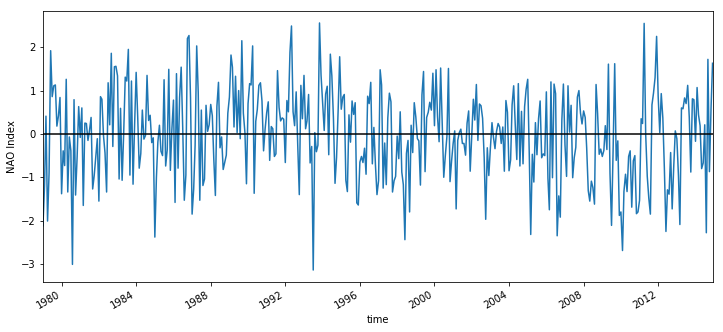

In [21]:
nao.plot()
plt.axhline(0, color = 'k');
plt.ylabel('NAO Index');
plt.xlim(['1979-01-01', '2014-12-01']);

To be able to create a scatter plot, we can now have a look the NAO index versus the temperatures over norway!
Load the temperature dataset, select and average over a part norway and take the winter season again:

In [24]:
t2m = xr.open_dataset('./data/ERA5-LowRes-MonthlyAvg-t2m_tp.nc').t2m.sel(time = slice('1979','2014'))
t2m_nor = t2m.sel(latitude = slice(63,60), longitude = slice(8.5,10.5)).mean(dim = ['latitude', 'longitude']) - 273.15
t2m_nor

<xarray.DataArray 't2m' (time: 432)>
array([-14.438538, -10.585846,  -4.79303 , ...,   4.011993,  -1.146057,
        -6.685852], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01

In [25]:
t2m_nor = t2m_nor.where(t2m_nor['time.season'] == 'DJF') #select winter season since correlation is strongest here
t2m_nor = t2m_nor.groupby('time.year').mean('time') #average over the year (over each season)

nao = nao.where(nao['time.season'] == 'DJF') 
nao = nao.groupby('time.year').mean('time') 

Let's have a look at the scatter plot to get a first idea of the correlation:

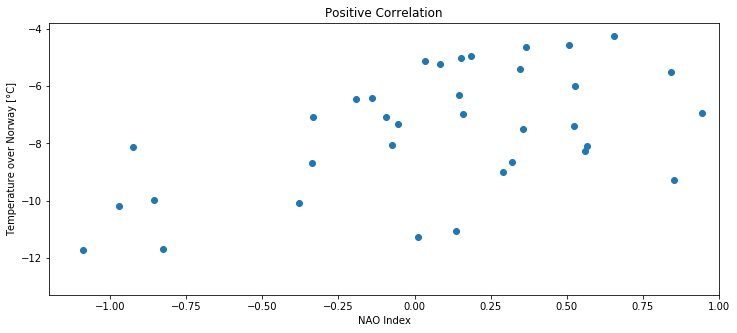

In [26]:
plt.scatter(nao, t2m_nor)
plt.xlabel('NAO Index');
plt.ylabel('Temperature over Norway [°C]');
plt.title('Positive Correlation')
plt.xlim([-1.2,1.0]);

Now, we want to create a map of europe with the correlation values of NAO Index with temperatures.
In order to do that, we need a for loop again. 

In [27]:
t2m = t2m.where(t2m['time.season'] == 'DJF') #select winter season since correlation is strongest here
t2m = t2m.groupby('time.year').mean('time') #average over the year (over each season)

In [28]:
# first, we make an empty array that we will fill with the correlation coefficients of each grid point
cor_map = t2m[0,:,:] * 0.
# for loops over lats and lons
for j in np.arange(len(t2m.latitude)):
    for i in np.arange(len(t2m.longitude)):
        cor_map.values[j, i] = np.corrcoef(t2m.values[:, j, i], nao.values)[0, 1]

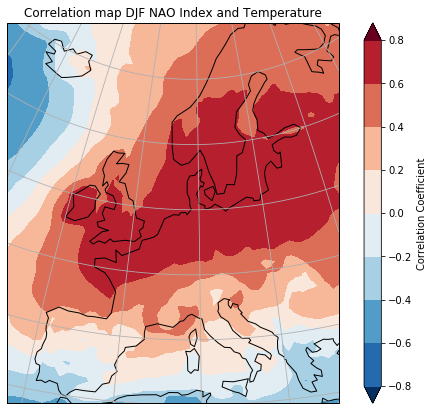

In [29]:
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.EuroPP()) # take the projection for europe 
ax.coastlines(); ax.gridlines();
cs = cor_map.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'Correlation Coefficient'}, 
                           levels=np.linspace(-0.8, 0.8, 9), extend='both')
plt.title('Correlation map DJF NAO Index and Temperature');

As already expected when trying to understand the plots from Wanner, H., Brönnimann, S., Casty, C., et al. (2001) at the very beginning of this chapter, NAO and temperatures over northern europe are highly positive correlated. This means, NAO+ causes the temperatures over northern europe to be higher than the mean.